## Importing the modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

####  Line search by Armijo Rule

In [2]:
# -------------------------------------------------------------------
# METODO: LSArmijo
# Armijo Criterion for Line Search
# -------------------------------------------------------------------

def LSArmijo(Fnome, X, d,g):
    rho1 = 0.85
    rho2 = 0.15
    nUP = 2          # coefficient for interval increment
    ndown = 0.7      # coefficient for backtracking
    
    g0 = g           # f'(0)
    f0 = Fnome(X)    # f(0)
    s = 2          # Initial Step value
    
    Xs  = X + s*d     # X(s)
    fXs = Fnome(Xs)   # f(Xs) 
    
    #DENTRO DA condição (9.4)livro do ARORA
    data = []
    gfd = np.dot(np.array(g0).T,d)
    i = 0
    if gfd > 0:
        print('No descent direction')

    while fXs <= f0 + s*rho1*np.dot(np.array(g0),d):
        s = nUP*s
        Xs = X + s*d
        fXs = Fnome(Xs)
        i=i+1
    
    while fXs > f0 + s*rho2*np.dot(np.array(g0),d):
        if s < 5*10**-2:
            s = 5*10**-2
            break
        s = ndown*s
        Xs = X+s*d
        fXs = Fnome(Xs)
        i=i+1
    
    return s, Xs, i

## Descent direction search  Gradient, Newton's and Quasi-Newton's  method

In [3]:
#-------------------------------------------------------------------
# [X,f,g] = Newton (Fnome, Gnome, Hnome, X0, Type)
# X = Optimal solution
# f = Optimal value of objective function
# g = Optimal value of gradient of objective function
# Fnome = name of objective function f = Fnome(X0)
# Gnome = name of gradient of objective function g = Gnome(X0)
# Hnome = name of Hessian of objective function h = Hnome(X0)
# X0 = Initial point
# Type = Type of algorithm: 0=Gradient; 1=Newton; 2=BFGS; 3=DFP; 4=Gradiente Conjugado

# -------------------------------------------------------------------

# LS

def QNewton(Fnome, Gnome, X0, Type,LS,Silent = False):
    
    # Maximum iteration number
    NIter = 100000;

    # Gradient of cost function at X0
    g0 = Gnome(X0)
    
    #Convergence test at X0
    Epsilon  = 1.e-8*np.linalg.norm(g0)
    if np.linalg.norm(g0) < Epsilon:
        return 
    
    #Inicialization
    X = X0
    dim = np.size(X)
    H = np.identity(dim)
    g = Gnome(X)
    count = 0
    points = []
    it_line = 0
    
    #Iterations
    for i in range(NIter):
        
        
        Inv = False
        eps = 0.1
        Theta = 0.001
        Beta = 0.001
        if Type == 0 or Type == 1 or Type == 2:
            while Inv == False:
                try:
                    d = -np.dot(np.linalg.inv(H),g)
                    if np.dot(g,d) >= -Theta*np.linalg.norm(g)*np.linalg.norm(d):
                        H = H + eps*np.identity(dim)
                        eps = 2*eps
                    else:
                        Inv = True
                except:
                    H = H + eps*np.identity(dim)
                    eps = 2*eps
                    
        elif Type == 4:
            if i ==0:
                gx = g
                d  = -np.dot(H,g)
                d_ = d
            else:
                fac = (np.linalg.norm(g)/np.linalg.norm(gx))**2
                d  = -np.dot(H,g) + fac*d_
                d_ = d
                gx = g
            
        elif Type == 3:
            d = -np.dot(H,g)
            if np.dot(g,d) >= -Theta*np.linalg.norm(g)*np.linalg.norm(d):
                        H = H + eps*np.identity(dim)
                        eps = 2*eps

        if np.linalg.norm(d) < Beta*np.linalg.norm(g):
            d = d/np.linalg.norm(d)*Beta*np.linalg.norm(g)

        #Line Search
        if LS == 0:
            [s,X1,it_l] = LSArmijo(Fnome, X, d, g)
        elif LS == 1:
            [s,X1,it_l] = GldSrc(Fnome, X, d)
        elif LS == 2:
            [s,X1,it_l] = LSPolynomial(Fnome, X, d)
        
        it_line = it_line + it_l
        
        
        #Convergence Verification
        
        f1 = Fnome(X1)
        g1 = Gnome(X1)
        
        norma = (np.linalg.norm(g1))
        
        if norma < Epsilon:
            print('Convergence OK!')
            print("Descent Iteration number", i)
            print("Line Search Total Iteration number", it_line)
            print("f  =" + str(f1) + " Step = " + str(s))
            print("X  =" + str(X1))
            print("g/go  = " + str(g1))
            return (X1,f1,g1,i) 
      
        if Type == 0:
            #Gradient Descent
            H = np.identity(dim)
        elif Type == 1:
            #Newton
            H = Hnome(X1)
            
        elif Type == 2: 
            #if np.linalg.norm(g1 - g) != 0:
                #BFGS
            s_k = np.reshape(np.array([s*d]),(dim,1))
            c_k = np.reshape(np.array([g]),(dim,1)) 
            c_k1 = np.reshape(np.array([g1]),(dim,1)) 
            y_k = np.reshape(np.array([g1- g]),(dim,1))

            H1 = y_k@y_k.T/(y_k.T@s_k)
            H2 = -(H@s_k@s_k.T@H)/(s_k.T@H@s_k)

            Hk = H + H1 + H2
            H = Hk
            
        elif Type == 3:
            #DFP
            s_k = np.reshape(np.array([s*d]),(dim,1))
            y_k = np.reshape(np.array([g1- g]),(dim,1))
            
            Bk = (s_k@s_k.T)/(y_k.T@s_k)
            #Ck = (-z_k@z_k.T)/(y_k@z_k)
            Ck = -(H@y_k@y_k.T@H)/(y_k.T@H@y_k)
            
            Hk= H +Bk + Ck
            H = Hk
        
        elif Type == 4:
            #Gradiente Conjugado
            pass 

        X = X1
        g = g1
 
    return (X,f1,g1,i)

#### Penalized Objective Function

In [4]:
def f_pen(x):
        
    k1 = x[0]*E/(2*L1)
    k2 = x[1]*E/L2
    k3 = x[2]*E/L3

    K = np.array([[k1+k3, -k1  , -k1],[-k1  , k1+k2,  k1], [-k1  , k1   , k1 ]])
    U = np.linalg.inv(K)@F

    f = 0.5*F.T@U + rho/2*(max(0,(x[0]*L1 + x[1]*L2 + x[2]*L3 - V_max))**2
                  + max(0,(-x[0]+A_01))**2
                  + max(0,(-x[1]+A_02))**2
                  + max(0,(-x[2]+A_03))**2
                          )
    
    return f

#### Gradient of the Penalized Objective Function

In [5]:
def g_pen(x):
    
    k1 = x[0]*E/(2*L1)
    k2 = x[1]*E/L2
    k3 = x[2]*E/L3

    K = np.array([[k1+k3, -k1  , -k1],[-k1  , k1+k2,  k1], [-k1  , k1   , k1 ]])
    U = np.linalg.inv(K)@F

    dK1 = E/(2*L1)*np.array([[1, -1  , -1],[-1  , 1,  1], [-1  , 1   , 1 ]])
    dK2 = E/L2*np.array([[0,  0  ,  0],[ 0  , 1,  0], [ 0  , 0   , 0 ]])
    dK3 = E/L3*np.array([[1,  0  ,  0],[ 0  , 0,  0], [ 0  , 0   , 0 ]])

    gf = np.zeros(3)
    

    gf[0] = -(dK1@U).T@U + rho*(max(0,L1*(x[0]*L1 + x[1]*L2 + x[2]*L3 - V_max))
    #gf[0] = F.T@np.linalg.inv(K)@(-(dK1@U)) + rho*(max(0,L1*(x[0]*L1 + x[1]*L2 + x[2]*L3 - V_max)) 
                                - max(0,(-x[0]+A_01))
                               )
    gf[1] = -(dK2@U).T@U + rho*(max(0,L2*(x[0]*L1 + x[1]*L2 + x[2]*L3 - V_max)) 
    #gf[1] = F.T@np.linalg.inv(K)@(-(dK2@U))+ rho*(max(0,L2*(x[0]*L1 + x[1]*L2 + x[2]*L3 - V_max)) 
                                - max(0,+(-x[1]+A_02))
                               )
    gf[2] = -(dK3@U).T@U + rho*(max(0,L3*(x[0]*L1 + x[1]*L2 + x[2]*L3 - V_max)) 
    #gf[2] = F.T@np.linalg.inv(K)@(-(dK3@U)) + rho*(max(0,L3*(x[0]*L1 + x[1]*L2 + x[2]*L3 - V_max)) 
                                - max(0,+(-x[2]+A_03))
                               )

    return gf.T

#### FIxed Parameters

In [6]:
# Comprimento das barras da Treliça
L1 = (1.5**2 + 1.5**2)**0.5*10**3
L2 = 1.5*10**3
L3 = 1.5*10**3

# Módulo de Elasticidade 
E = 2*10**11*10**-6

# Esforços Mecânicos
F = np.array([[0,500,-500]]).T

#### Restrictions of the Problem

In [7]:
# Máximo Volume
V_max = 3*10**-4*(L1+L2+L3)*10**6

#Áreas Mínimas
A_01 = 0
A_02 = 0
A_03 = 0

In [8]:
#intial point
x_init = 10**6*np.array([3*10**-4,3*10**-4,3*10**-4])

#### Penalization factor

In [9]:
rho_vec = [10**-2,10**-3,10**-4,10**-5,10**-6,10**-7,10**-8,10**-9,10**-10,10**-11]

In [10]:
Minimizadores = []
Minimos = []
Iterações = []
for i in rho_vec:
    print('The penalization factor is ' +str(i))
    rho = i
    X = QNewton(f_pen,g_pen,x_init,2,0)
    Minimizadores.append(X[0])
    Minimos.append(X[1][0][0])
    Iterações.append(X[3])
    print()

The penalization factor is 0.01

The penalization factor is 0.001
Convergence OK!
Descent Iteration number 12253
Line Search Total Iteration number 133395
f  =[[22.88228272]] Step = 0.16470859999999993
X  =[289.7056331  409.70563543 204.85281771]
g/go  = [3.01643072e-10 2.13261200e-10 2.13292189e-10]

The penalization factor is 0.0001
Convergence OK!
Descent Iteration number 3381
Line Search Total Iteration number 36514
f  =[[22.88228272]] Step = 0.08070721399999996
X  =[289.70568365 409.70570692 204.85285346]
g/go  = [-7.12946063e-10 -5.04113376e-10 -5.04124506e-10]

The penalization factor is 1e-05
Convergence OK!
Descent Iteration number 342
Line Search Total Iteration number 3552
f  =[[22.88228272]] Step = 0.05
X  =[289.70618915 409.7064218  204.85321091]
g/go  = [-7.31440436e-10 -5.16776628e-10 -5.12821612e-10]

The penalization factor is 1e-06
Convergence OK!
Descent Iteration number 367
Line Search Total Iteration number 3734
f  =[[22.88228271]] Step = 0.05
X  =[289.71124394 409

#### Minimums

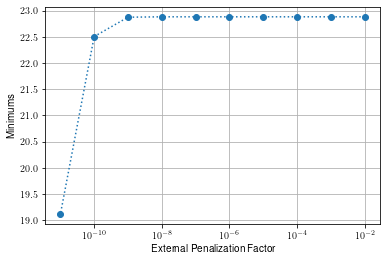

In [11]:
plt.semilogx(rho_vec,np.array(Minimos),'o:')
plt.grid()
plt.xlabel('External Penalization Factor')
plt.ylabel('Minimums')
plt.savefig('Minimums.pdf',format = 'pdf',bbox_inches='tight')

#### Minimizers

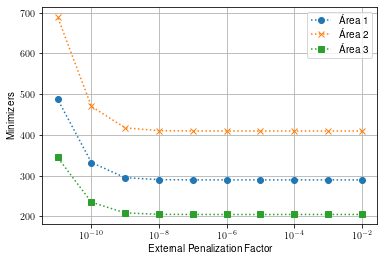

In [12]:
plt.semilogx(rho_vec,np.array(Minimizadores).T[0],'o:', label = 'Área 1')
plt.semilogx(rho_vec,np.array(Minimizadores).T[1],'x:', label = 'Área 2')
plt.semilogx(rho_vec,np.array(Minimizadores).T[2],'s:', label = 'Área 3')
plt.grid()
plt.legend()
plt.xlabel('External Penalization Factor')
plt.ylabel('Minimizers')
plt.savefig('Minimizers.pdf',format = 'pdf',bbox_inches='tight')

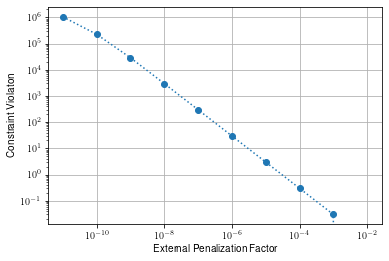

In [13]:
plt.loglog(rho_vec,np.array(Minimizadores)@np.array([L1,L2,L3])-V_max,'o:')
plt.grid()
plt.xlabel('External Penalization Factor')
plt.ylabel('Constraint Violaton')
plt.savefig('Violation.pdf',format = 'pdf',bbox_inches='tight')

#### Número de Iterações na direção de descida Necessárias

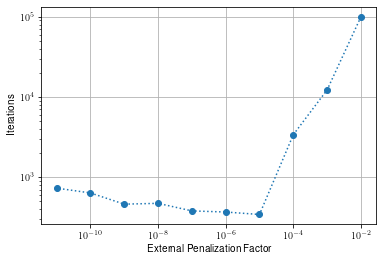

In [14]:
plt.loglog(rho_vec,np.array(Iterações),'o:')
plt.grid()
plt.xlabel('External Penalization Factor')
plt.ylabel('Iterations')
plt.savefig('Iterations.pdf',format = 'pdf',bbox_inches='tight')

#### Augmented Lagrangian Functions

In [15]:
def f_lag(x):
    
    
    k1 = x[0]*E/(2*L1)
    k2 = x[1]*E/L2
    k3 = x[2]*E/L3

    K = np.array([[k1+k3, -k1  , -k1],[-k1  , k1+k2,  k1], [-k1  , k1   , k1 ]])
    U = np.linalg.inv(K)@F

    f = 0.5*F.T@U + (Mu[0]*(max(0,(x[0]*L1 + x[1]*L2 + x[2]*L3 - V_max))) + rho/2*(max(0,(x[0]*L1 + x[1]*L2 + x[2]*L3 - V_max))**2)
                  +  Mu[1]*max(0,(-x[0]+A_01))                            + rho/2*(max(0,(-x[0]+A_01))**2)
                  +  Mu[2]*max(0,(-x[0]+A_01))                            + rho/2*(max(0,(-x[1]+A_02))**2)
                  +  Mu[3]*max(0,(-x[0]+A_01))                            + rho/2*(max(0,(-x[2]+A_03))**2))
    
    return f

#### Gradient of the Augmented Lagrangian Functions

In [16]:
def g_lag(x):
    
    k1 = x[0]*E/(2*L1)
    k2 = x[1]*E/L2
    k3 = x[2]*E/L3

    K = np.array([[k1+k3, -k1  , -k1],[-k1  , k1+k2,  k1], [-k1  , k1   , k1 ]])
    U = np.linalg.inv(K)@F

    dK1 = E/(2*L1)*np.array([[1, -1  , -1],[-1  , 1,  1], [-1  , 1   , 1 ]])
    dK2 = E/L2*np.array([[0,  0  ,  0],[ 0  , 1,  0], [ 0  , 0   , 0 ]])
    dK3 = E/L3*np.array([[1,  0  ,  0],[ 0  , 0,  0], [ 0  , 0   , 0 ]])

    gf = np.zeros(3)
    
    S0 = 0
    S1 = 0
    S2 = 0
    
    g_in = g_ineq(x)
    for j in range(4):
        if g_in[j] > -Mu[j]/rho:
            S0 = S0 +(Mu[j] + rho*g_in[j])*dg_dA1[j]
            S1 = S1 +(Mu[j] + rho*g_in[j])*dg_dA2[j]
            S2 = S2 +(Mu[j] + rho*g_in[j])*dg_dA3[j]
    
    gf[0] = -(dK1@U).T@U + S0
                        
    gf[1] = -(dK2@U).T@U + S1
                               
    gf[2] = -(dK3@U).T@U + S2

    return gf.T

#### Inequalityy restrictions

In [17]:
def g_ineq(x):
    g_in = np.zeros(4)
    g_in[0] = (x[0]*L1 + x[1]*L2 + x[2]*L3 - V_max)
    g_in[1] = (-x[0]+A_01)
    g_in[2] = (-x[1]+A_02)
    g_in[3] = (-x[2]+A_03)
    return g_in

In [18]:
def max_vec(vec):
    mx = []
    for i in vec:
        mx.append(max(0,i))
    return np.array(mx)

In [19]:
dg_dA1 = [L1, -1,  0,  0]
dg_dA2 = [L2,  0, -1,  0]
dg_dA3 = [L3,  0,  0, -1]

In [20]:
x_init = 10**6*np.array([3*10**-4,3*10**-4,3*10**-4])
Beta = 2

#### Case 1

In [21]:
rho = 10**-10
Mu  = np.array([1,1,1,1])*10**-10

In [22]:
it = 1000
f_p = f_lag(x_init) 
for i in range(it):
    print(i)
    X = QNewton(f_lag,g_lag,x_init,2,0)
    Epsilon =  np.abs(g_ineq(X[0])@Mu)
    if Epsilon < 10**-3 and (f_p - X[1])/f_p < 10**-6:
        print()
        print('Final Convergence!')
        print('Os Valored de Mu são ' + str (Mu))
        print('O Valor de Rho é = ' + str (rho))
        print('Os Minimizadores são = ' + str (X[0]))
        break
    Mu = Mu + rho*max_vec(g_ineq(X[0]))
    rho = rho*Beta
    f_p = X[1]
    print()

0
Convergence OK!
Descent Iteration number 635
Line Search Total Iteration number 6461
f  =[[22.50515513]] Step = 0.05
X  =[332.3764722  470.05132098 235.02566073]
g/go  = [-9.31402525e-10  2.34706088e-10  3.03088367e-10]

1
Convergence OK!
Descent Iteration number 518
Line Search Total Iteration number 5595
f  =[[23.21457183]] Step = 0.05
X  =[295.38414017 417.73625856 208.86812906]
g/go  = [-4.79423973e-10 -4.62350783e-11 -1.36197262e-10]

2
Convergence OK!
Descent Iteration number 449
Line Search Total Iteration number 4791
f  =[[22.91926055]] Step = 0.05
X  =[290.19317487 410.39512499 205.19756265]
g/go  = [-4.52547722e-10 -1.87571139e-11  4.75400136e-11]

3
Convergence OK!
Descent Iteration number 346
Line Search Total Iteration number 3660
f  =[[22.88405234]] Step = 0.05
X  =[289.72810851 409.73742247 204.86871114]
g/go  = [-4.21541316e-10  1.39823209e-10  9.77529238e-11]

4
Convergence OK!
Descent Iteration number 209
Line Search Total Iteration number 2078
f  =[[22.88232472]] S

#### Case 2

In [23]:
rho = 10**-6
Mu  = np.array([1,1,1,1])*10**-10

In [24]:
it = 1000
f_p = f_lag(x_init) 
for i in range(it):
    print(i)
    X = QNewton(f_lag,g_lag,x_init,2,0)
    Epsilon =  np.abs(g_ineq(X[0])@Mu)
    if Epsilon < 10**-3 and (f_p - X[1])/f_p < 10**-6:
        print()
        print('Final Convergence!')
        print('Os Valored de Mu são ' + str (Mu))
        print('O Valor de Rho é = ' + str (rho))
        print('Os Minimizadores são = ' + str (X[0]))
        break
    Mu = Mu + rho*max_vec(g_ineq(X[0]))
    rho = rho*Beta
    f_p = X[1]
    print()

0
Convergence OK!
Descent Iteration number 367
Line Search Total Iteration number 3734
f  =[[22.88228271]] Step = 0.05
X  =[289.71124392 409.71357034 204.85678519]
g/go  = [-7.17629248e-10 -5.02444149e-10 -4.95420448e-10]

1
Convergence OK!
Descent Iteration number 148
Line Search Total Iteration number 1357
f  =[[22.88228273]] Step = 0.05
X  =[289.7056276  409.70562762 204.85281383]
g/go  = [-3.06562234e-10 -2.23179968e-10 -2.15075832e-10]

Final Convergence!
Os Valored de Mu são [2.97858023e-05 1.00000000e-10 1.00000000e-10 1.00000000e-10]
O Valor de Rho é = 2e-06
Os Minimizadores são = [289.7056276  409.70562762 204.85281383]


#### Case 3

In [25]:
rho = 10**-9
Mu  = np.array([1,1,1,1])*10**-7

In [26]:
it = 1000
f_p = f_lag(x_init) 
for i in range(it):
    print(i)
    X = QNewton(f_lag,g_lag,x_init,2,0)
    Epsilon =  np.abs(g_ineq(X[0])@Mu)
    if Epsilon < 10**-3 and (f_p - X[1])/f_p < 10**-6:
        print()
        print('Final Convergence!')
        print('Os Valored de Mu são ' + str (Mu))
        print('O Valor de Rho é = ' + str (rho))
        print('Os Minimizadores são = ' + str (X[0]))
        break
    Mu = Mu + rho*max_vec(g_ineq(X[0]))
    rho = rho*Beta
    f_p = X[1]
    print()

0
Convergence OK!
Descent Iteration number 427
Line Search Total Iteration number 4465
f  =[[22.876067]] Step = 0.05
X  =[295.09998539 417.3344059  208.66720344]
g/go  = [-8.42103887e-10  2.91631441e-10  4.96037364e-10]

1
Convergence OK!
Descent Iteration number 348
Line Search Total Iteration number 3654
f  =[[22.88987707]] Step = 0.05
X  =[289.80542777 409.84676426 204.92338217]
g/go  = [ 2.98754049e-10 -2.53633489e-10 -2.35394773e-10]

2
Convergence OK!
Descent Iteration number 208
Line Search Total Iteration number 2111
f  =[[22.88235831]] Step = 0.05
X  =[289.70658522 409.70698212 204.85349045]
g/go  = [-2.02378156e-10 -1.01477646e-10 -3.70477149e-10]

3
Convergence OK!
Descent Iteration number 135
Line Search Total Iteration number 1091
f  =[[22.88228308]] Step = 0.05
X  =[289.70563207 409.70563407 204.85281701]
g/go  = [-3.19534413e-10 -2.03878574e-10 -2.16618543e-10]

4
Convergence OK!
Descent Iteration number 48
Line Search Total Iteration number 143
f  =[[22.88228272]] Step 